<B>Giving Acess to GOOGLE Drive where the dataset is saved</B>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


<B>Unzipping the Files and saving them n the data</B>

In [ ]:
#  !unzip -q /content/drive/MyDrive/UTKFace.zip -d data

In [ ]:
!pip install tensorflow scikit-learn

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
DATA_DIR = "/content/data/UTKFace"
# Define constants
TRAIN_TEST_SPLIT = 0.7
IMAGE_SIZE = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}

# Generate reverse maps
GENDER_ID_MAP = {v: k for k, v in ID_GENDER_MAP.items()}
RACE_ID_MAP = {v: k for k, v in ID_RACE_MAP.items()}

# Display mappings
ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [ ]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [ ]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))
attributes = list(map(parse_filepath, files))

/content/data/UTKFace/61_1_20170109142408075.jpg.chip.jpg
/content/data/UTKFace/39_1_20170116174525125.jpg.chip.jpg
/content/data/UTKFace/61_1_20170109150557335.jpg.chip.jpg


In [ ]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

age  gender    race                                               file
0   1.0  female  others  /content/data/UTKFace/1_1_4_20161221193732358....
1  63.0    male   white  /content/data/UTKFace/63_0_0_20170104213529213...
2  25.0    male   white  /content/data/UTKFace/25_0_0_20170117175209600...
3   2.0  female  indian  /content/data/UTKFace/2_1_3_20161219230048688....
4  50.0    male  indian  /content/data/UTKFace/50_0_3_20170119205537439...

In [ ]:
df.describe()

age
count  23705.000000
mean      33.300907
std       19.885708
min        1.000000
25%       23.000000
50%       29.000000
75%       45.000000
max      116.000000

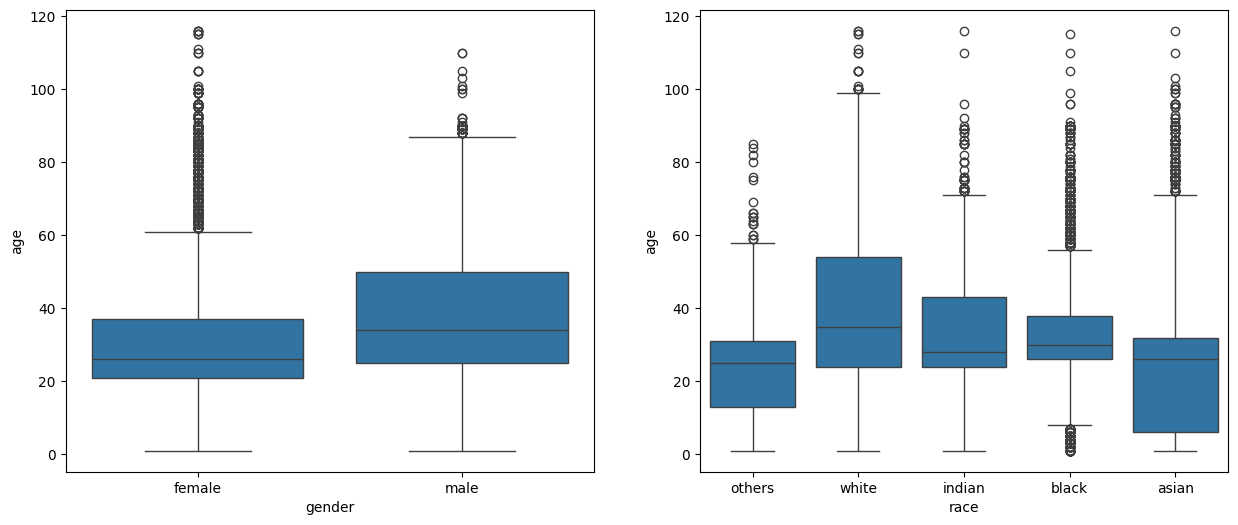

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

<Axes: xlabel='gender', ylabel='age'>

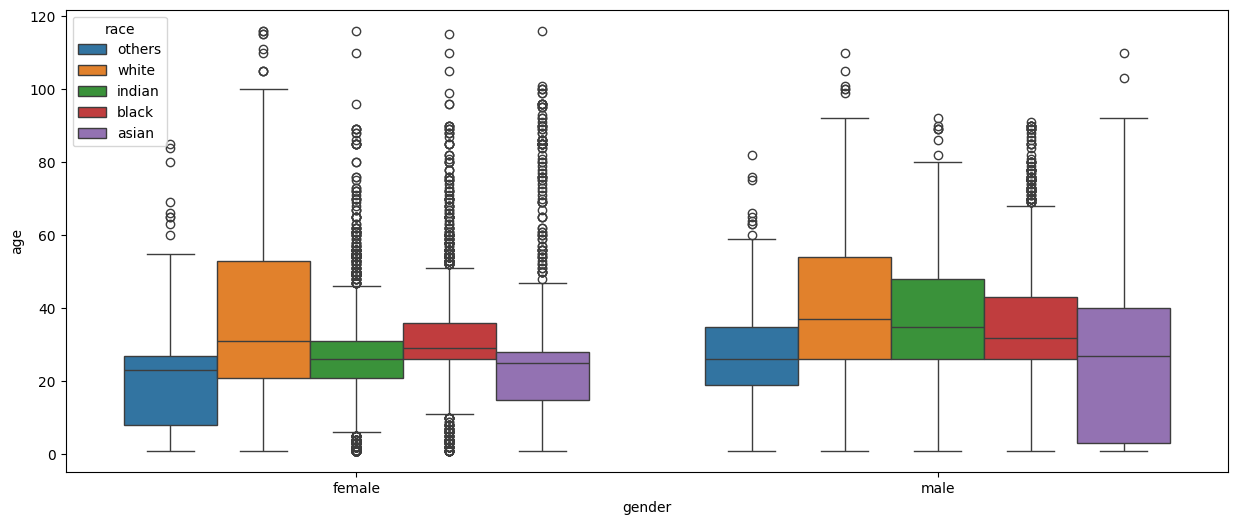

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

<Axes: xlabel='race,gender'>

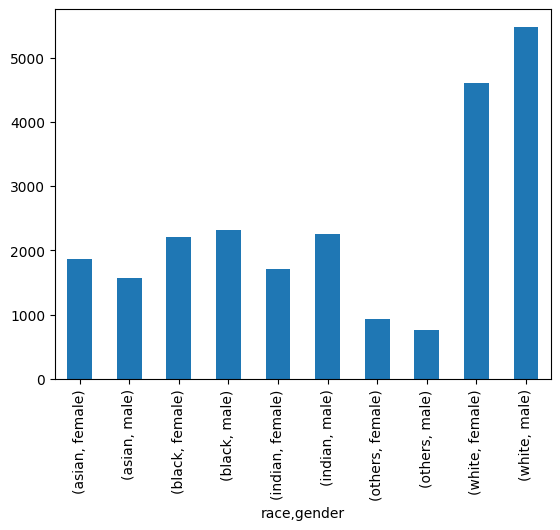

In [ ]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')


<Axes: >

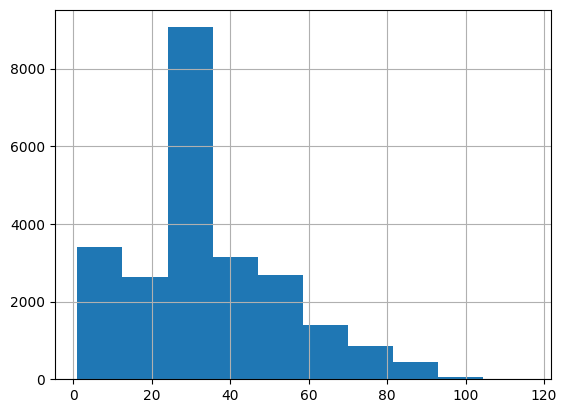

In [ ]:
df['age'].hist()


In [ ]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

(11615, 4978, 7112, 116.0)

In [ ]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

In [ ]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import SGD
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)

# for age calculation
_ = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(_)

# for race prediction
_ = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(_)

# for gender prediction
_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(_)

model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop',
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
# model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=10,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

<ipython-input-22-f3781bb6adfa>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/10
181/181 [==============================] - 78s 343ms/step - loss: 2.6804 - age_output_loss: 0.0506 - race_output_loss: 1.2861 - gender_output_loss: 0.6501 - age_output_mae: 0.1742 - race_output_accuracy: 0.5214 - gender_output_accuracy: 0.6910 - val_loss: 4.1235 - val_age_output_loss: 0.1028 - val_race_output_loss: 2.0948 - val_gender_output_loss: 0.7758 - val_age_output_mae: 0.2798 - val_race_output_accuracy: 0.4209 - val_gender_output_accuracy: 0.5517
Epoch 2/10
181/181 [==============================] - 71s 394ms/step - loss: 1.8224 - age_output_loss: 0.0256 - race_output_loss: 0.9162 - gender_output_loss: 0.3968 - age_output_mae: 0.1245 - race_output_accuracy: 0.6640 - gender_output_accuracy: 0.8200 - val_loss: 1.9958 - val_age_output_loss: 0.0257 - val_race_output_loss: 1.0127 - val_gender_output_loss: 0.4253 - val_age_output_mae: 0.1276 - val_race_output_accuracy: 0.6009 - val_gender_output_accuracy: 0.8009
Epoch 3/10
181/181 [==============================] - 64s 355m

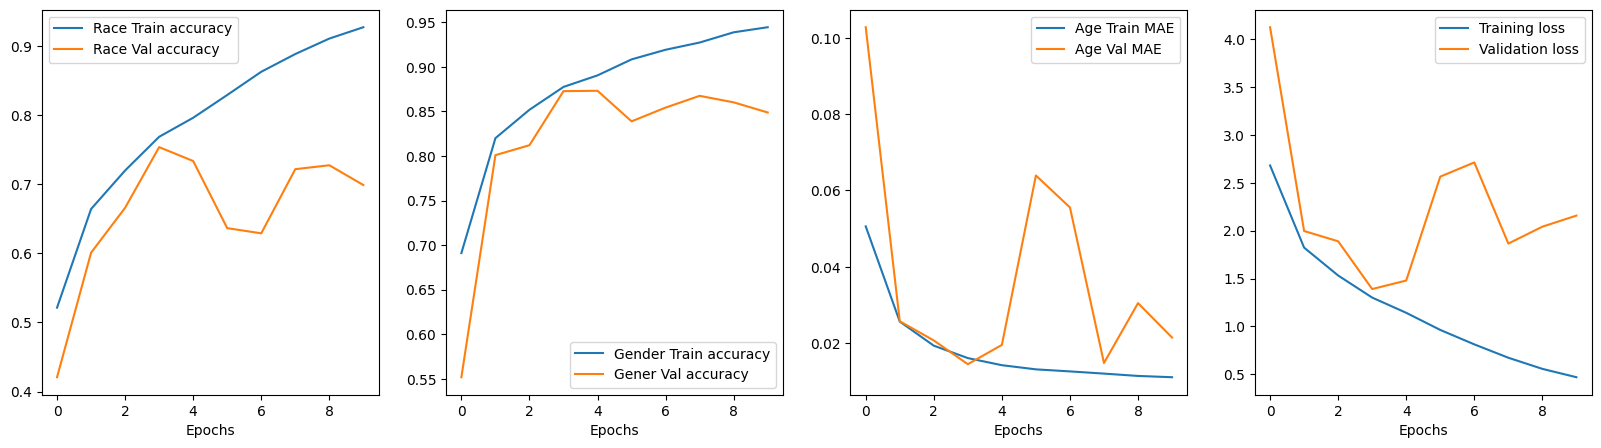

In [ ]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_loss'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_loss'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

In [ ]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

<ipython-input-24-d6456e542e93>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))


{'loss': 2.1770284175872803,
 'age_output_loss': 0.021567052230238914,
 'race_output_loss': 1.1514763832092285,
 'gender_output_loss': 0.40667960047721863,
 'age_output_mae': 0.1171402558684349,
 'race_output_accuracy': 0.6947442889213562,
 'gender_output_accuracy': 0.8509942889213562}

In [ ]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [ ]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.70      0.89      0.78        57
           1       0.83      0.75      0.79        20
           2       0.71      0.94      0.81        18
           3       0.89      0.33      0.48        24
           4       0.25      0.11      0.15         9

    accuracy                           0.72       128
   macro avg       0.68      0.61      0.60       128
weighted avg       0.73      0.72      0.69       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        68
           1       0.82      0.77      0.79        60

    accuracy                           0.81       128
   macro avg       0.81      0.81      0.81       128
weighted avg       0.81      0.81      0.81       128



<ipython-input-27-486a127d90fe>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('a:{}, g:{}, r:{}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))


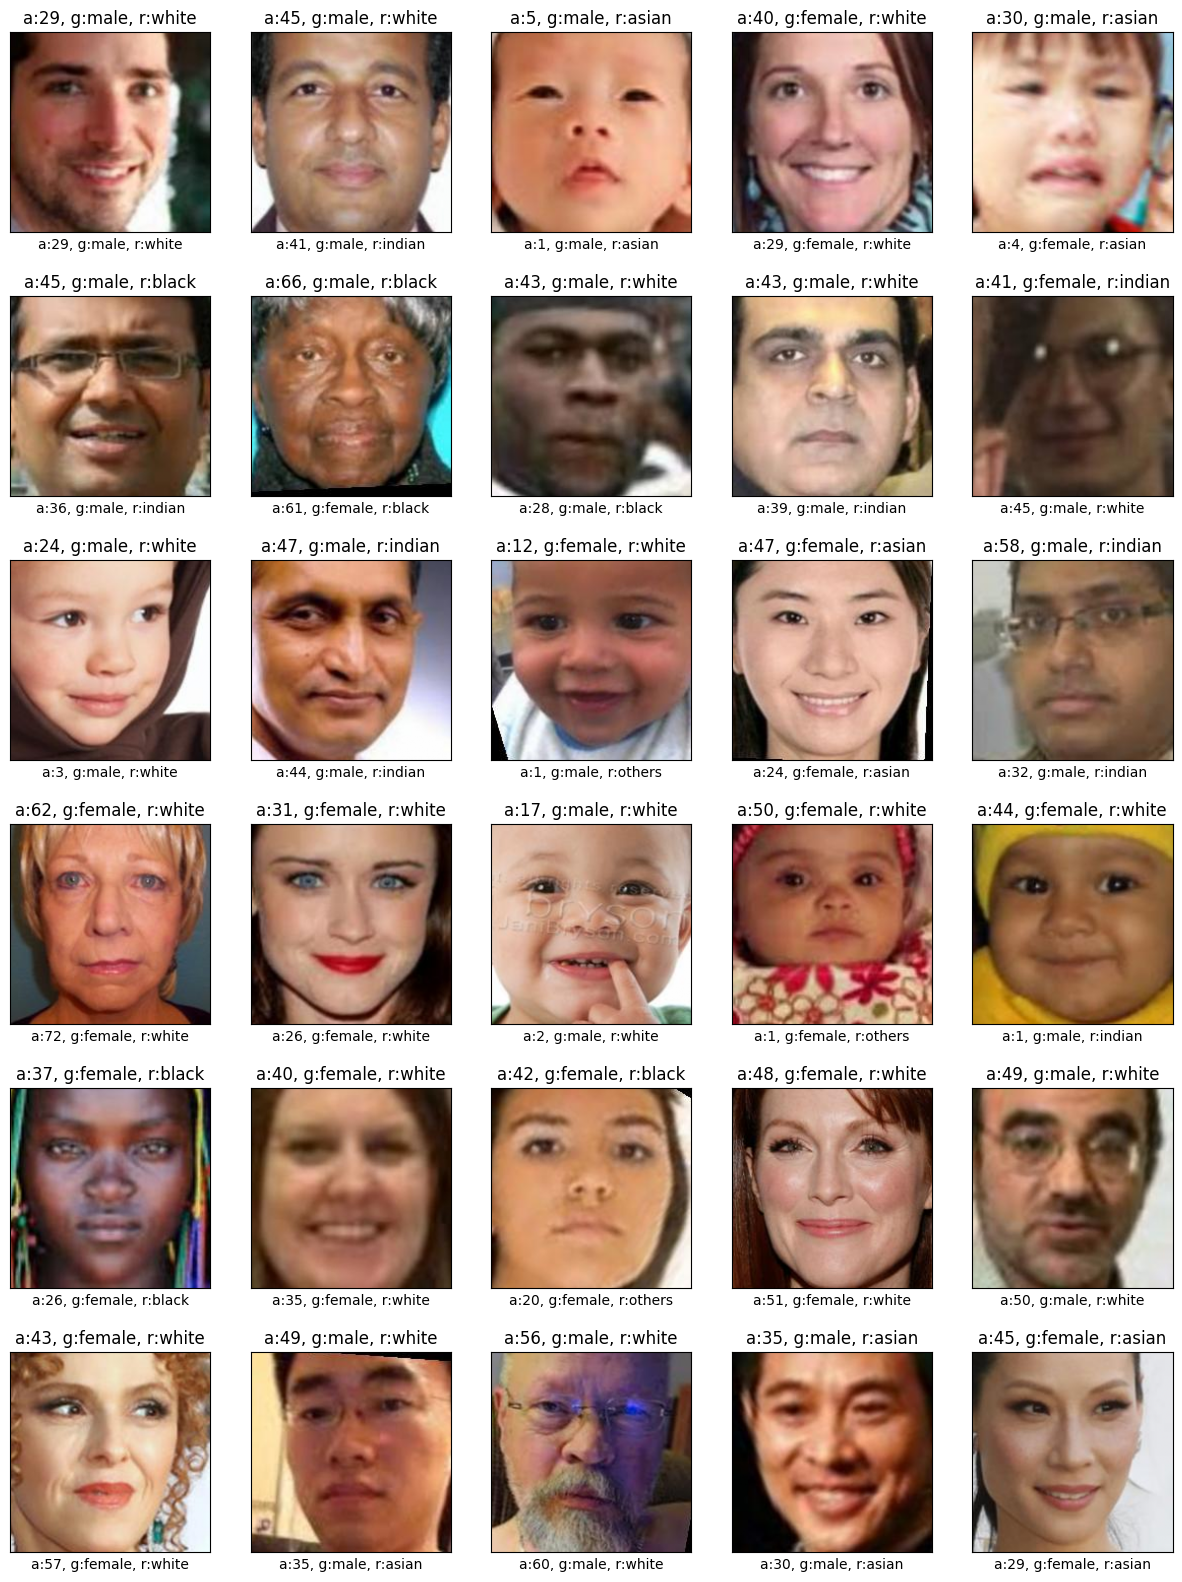

In [ ]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx]], ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])

**RESNET Architecture**

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Define ResNet model architecture
def build_model():
    base_model = ResNet50(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    age_output = Dense(1, activation='linear', name='age_output')(x)
    race_output = Dense(len(RACE_ID_MAP), activation='softmax', name='race_output')(x)
    gender_output = Dense(2, activation='softmax', name='gender_output')(x)
    model = Model(inputs=base_model.input, outputs=[age_output, race_output, gender_output])
    return model


In [ ]:
model = build_model()

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# Compile model
model.compile(optimizer=Adam(),
              loss={'age_output': 'mean_squared_error',
                    'race_output': 'categorical_crossentropy',
                    'gender_output': 'categorical_crossentropy'},
              metrics={'age_output': 'mae',
                       'race_output': 'accuracy',
                       'gender_output': 'accuracy'})

# Define checkpoint to save the best model
checkpoint = ModelCheckpoint('resnet_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [ ]:
# Train model
history = model.fit(get_data_generator(df, train_idx, for_training=True, batch_size=16),
                    steps_per_epoch=len(train_idx) // 16,
                    epochs=10,
                    validation_data=get_data_generator(df, valid_idx, for_training=True, batch_size=16),
                    validation_steps=len(valid_idx) // 16,
                    callbacks=[checkpoint])


Epoch 1/10
725/725 [==============================] - ETA: 0s - loss: 1.3577 - age_output_loss: 0.0708 - race_output_loss: 0.9112 - gender_output_loss: 0.3756 - age_output_mae: 0.1479 - race_output_accuracy: 0.6742 - gender_output_accuracy: 0.8324
Epoch 1: val_loss improved from inf to 1.84096, saving model to resnet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


725/725 [==============================] - 187s 208ms/step - loss: 1.3577 - age_output_loss: 0.0708 - race_output_loss: 0.9112 - gender_output_loss: 0.3756 - age_output_mae: 0.1479 - race_output_accuracy: 0.6742 - gender_output_accuracy: 0.8324 - val_loss: 1.8410 - val_age_output_loss: 0.0392 - val_race_output_loss: 1.2598 - val_gender_output_loss: 0.5420 - val_age_output_mae: 0.1531 - val_race_output_accuracy: 0.5336 - val_gender_output_accuracy: 0.7112
Epoch 2/10
725/725 [==============================] - ETA: 0s - loss: 0.9109 - age_output_loss: 0.0144 - race_output_loss: 0.6371 - gender_output_loss: 0.2595 - age_output_mae: 0.0939 - race_output_accuracy: 0.7747 - gender_output_accuracy: 0.8909
Epoch 2: val_loss improved from 1.84096 to 1.37903, saving model to resnet_model.h5
725/725 [==============================] - 150s 207ms/step - loss: 0.9109 - age_output_loss: 0.0144 - race_output_loss: 0.6371 - gender_output_loss: 0.2595 - age_output_mae: 0.0939 - race_output_accuracy: 0.77

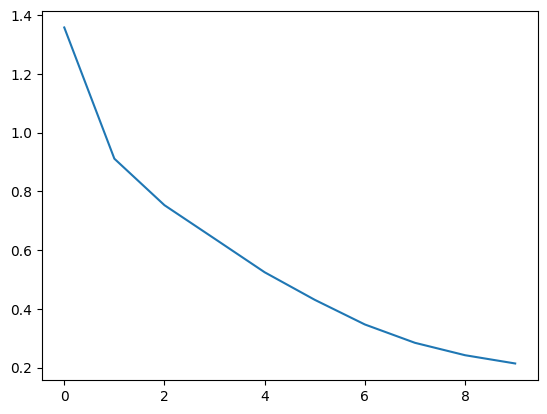

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')

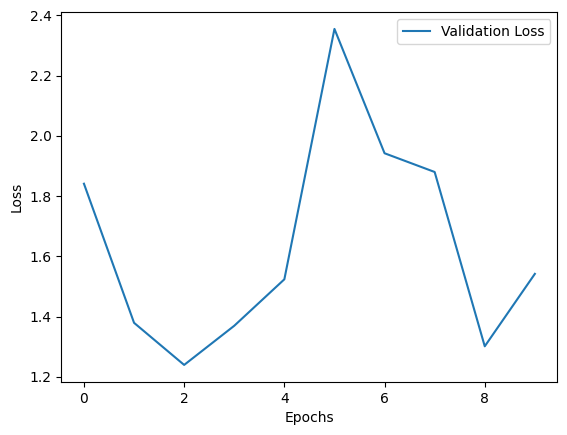

In [ ]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate model on test data
model.evaluate(get_data_generator(df, test_idx, for_training=False, batch_size=16))

444/444 [==============================] - 26s 59ms/step - loss: 1.4574 - age_output_loss: 0.0157 - race_output_loss: 1.0498 - gender_output_loss: 0.3919 - age_output_mae: 0.1012 - race_output_accuracy: 0.7262 - gender_output_accuracy: 0.8802


[1.4574071168899536,
 0.015695372596383095,
 1.0497828722000122,
 0.3919292092323303,
 0.10117222368717194,
 0.7262105941772461,
 0.8802083134651184]

In [ ]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

<ipython-input-37-d6456e542e93>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))


{'loss': 1.4586104154586792,
 'age_output_loss': 0.01570959761738777,
 'race_output_loss': 1.050321102142334,
 'gender_output_loss': 0.3925798535346985,
 'age_output_mae': 0.10120048373937607,
 'race_output_accuracy': 0.7257102131843567,
 'gender_output_accuracy': 0.8801136612892151}

In [ ]:
# Print classification reports
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.70      0.89      0.78        57
           1       0.83      0.75      0.79        20
           2       0.71      0.94      0.81        18
           3       0.89      0.33      0.48        24
           4       0.25      0.11      0.15         9

    accuracy                           0.72       128
   macro avg       0.68      0.61      0.60       128
weighted avg       0.73      0.72      0.69       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        68
           1       0.82      0.77      0.79        60

    accuracy                           0.81       128
   macro avg       0.81      0.81      0.81       128
weighted avg       0.81      0.81      0.81       128



<ipython-input-39-f9ac99610d7b>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]],


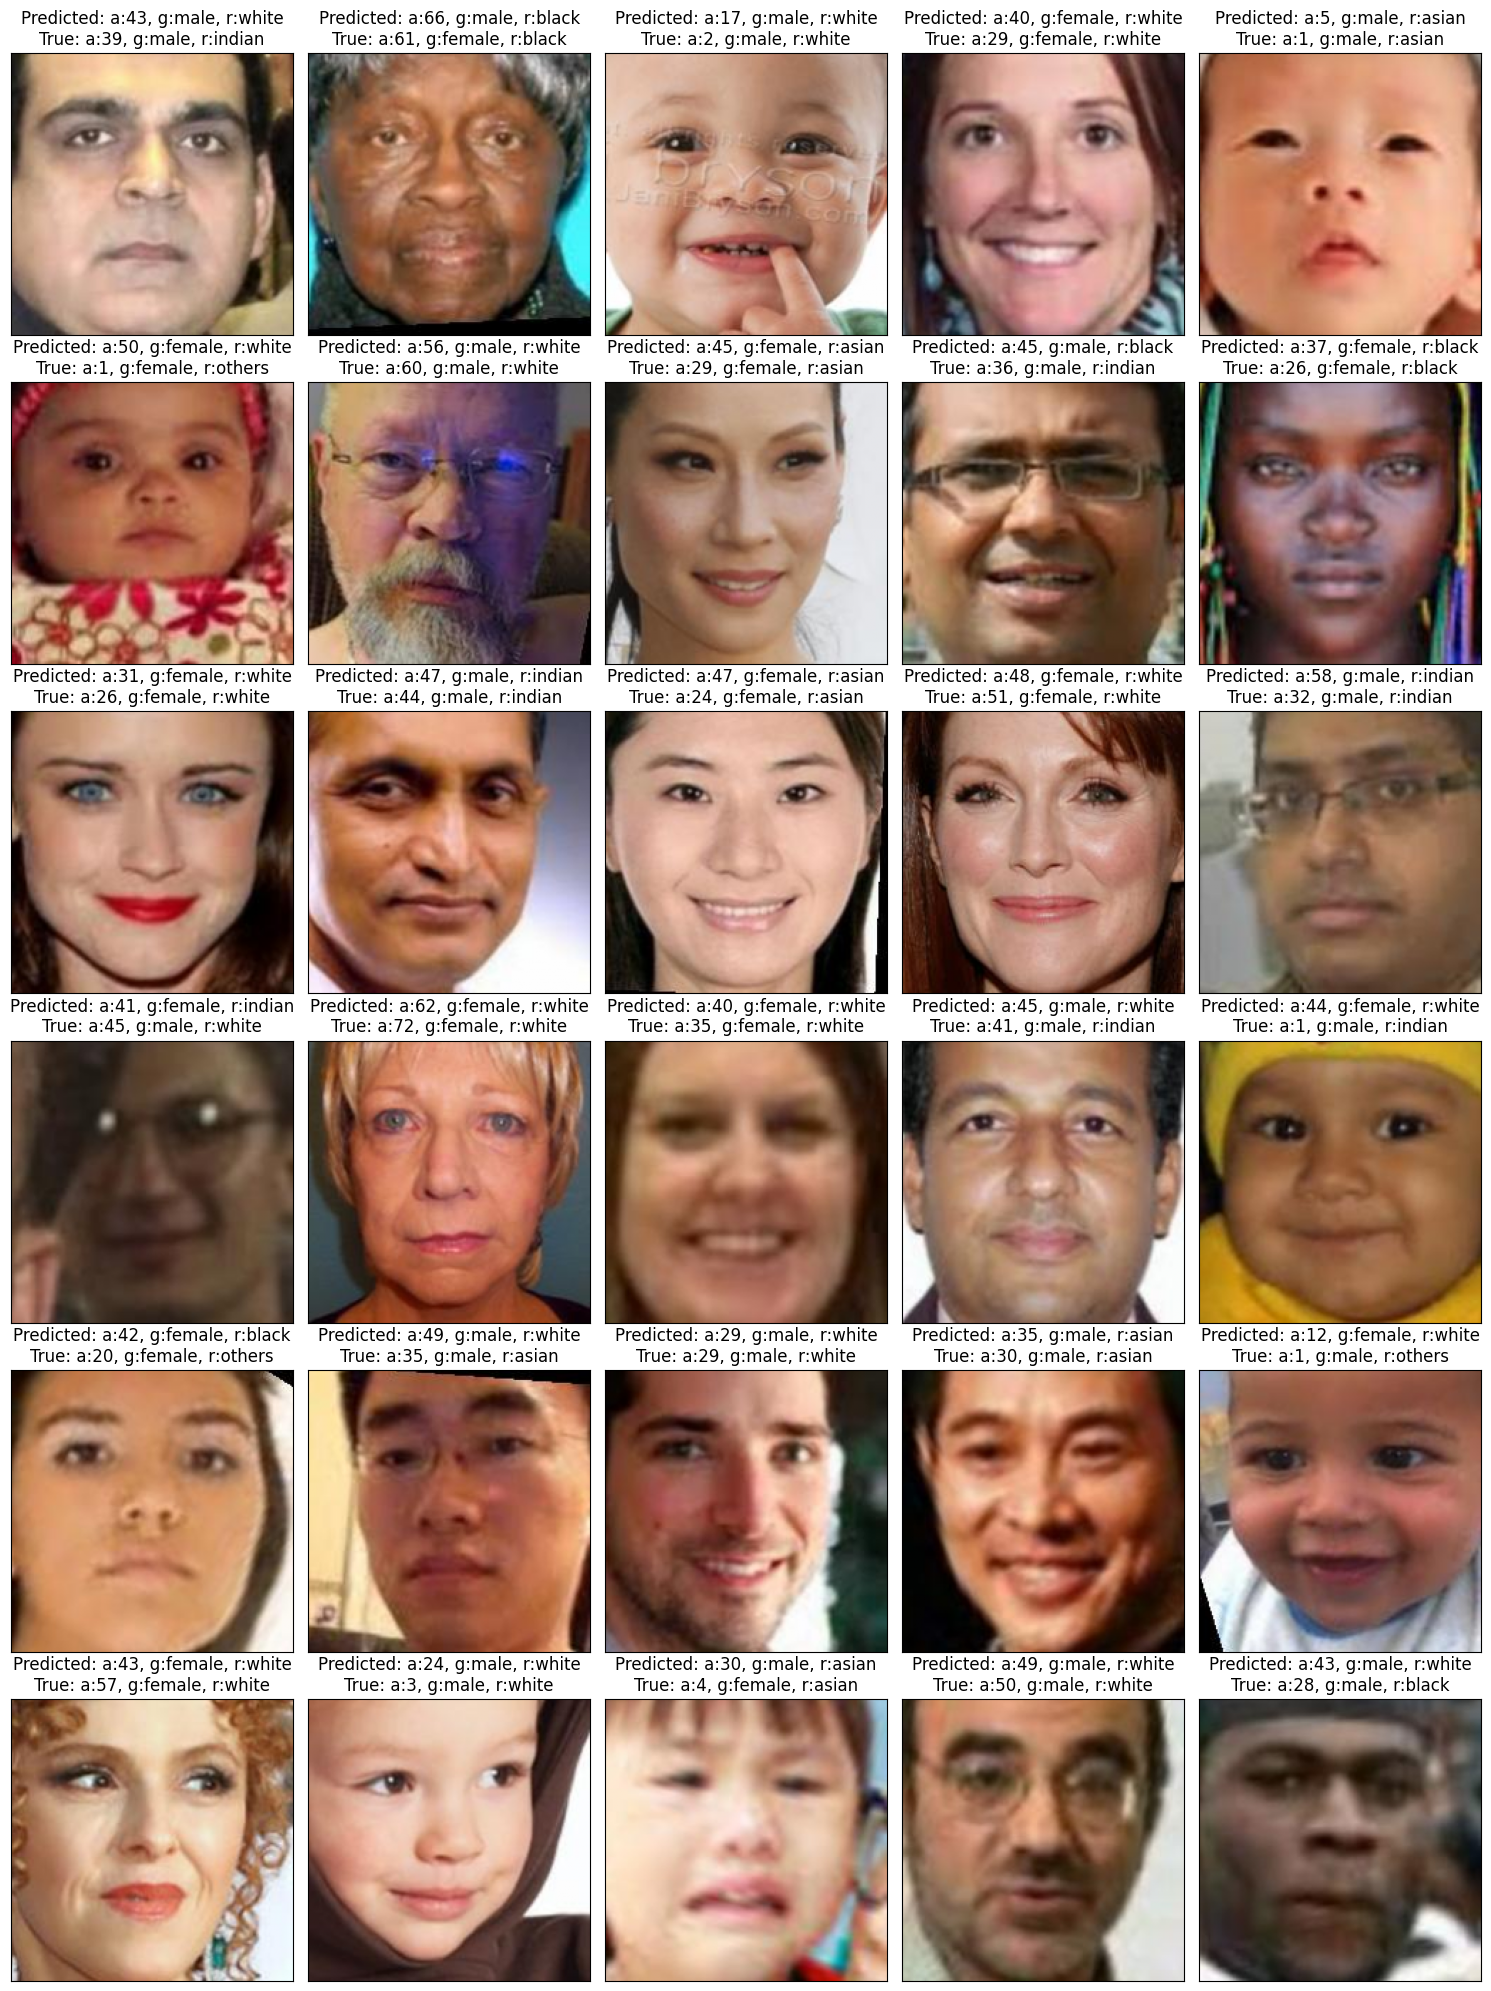

In [ ]:
# Plot images with predicted and true labels
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('Predicted: a:{}, g:{}, r:{}\nTrue: a:{}, g:{}, r:{}'.format(
        int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]],
        int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx]], ID_RACE_MAP[race_true[img_idx]]
    ))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()